# The Bank Marketing Problem  

## Client Atributes

| Column      | Description                                                                                    |
| ----------- | ---------------------------------------------------------------------------------------------- |
| `age`       | Age of the client (numeric).                                                                   |
| `job`       | Type of job (categorical). Examples: `admin.`, `technician`, `blue-collar`, `management`, etc. |
| `marital`   | Marital status (categorical). Values: `married`, `single`, `divorced`.                         |
| `education` | Education level (categorical). Values: `primary`, `secondary`, `tertiary`, `unknown`.          |
| `default`   | Has credit in default? (categorical). Values: `yes`, `no`, `unknown`.                          |
| `balance`   | Average yearly balance in euros (numeric).                                                     |
| `housing`   | Has a housing loan? (categorical). Values: `yes`, `no`, `unknown`.                             |
| `loan`      | Has a personal loan? (categorical). Values: `yes`, `no`, `unknown`.                            |

## Contact attributes

| Column     | Description                                                                                                                |
| ---------- | -------------------------------------------------------------------------------------------------------------------------- |
| `contact`  | Communication type (categorical). Values: `cellular`, `telephone`.                                                         |
| `day`      | Last contact day of the month (numeric).                                                                                   |
| `month`    | Last contact month of the year (categorical). Values: `jan`, `feb`, `mar`, etc.                                            |
| `duration` | Last campaign contact duration, in seconds (numeric).  |

## Campaing Attributes

| Column     | Description                                                                                                                           |
| ---------- | ------------------------------------------------------------------------------------------------------------------------------------- |
| `campaign` | Number of contacts performed during this campaign for this client (numeric, includes last contact).                                   |
| `pdays`    | Number of days that passed after the client was last contacted in a previous campaign (-1 means client was not previously contacted). |
| `previous` | Number of contacts performed before this campaign for this client (numeric).                                                          |
| `poutcome` | Outcome of the previous marketing campaign (categorical). Values: `success`, `failure`, `other`, `unknown`.                           |


## Dataset Exploration

A preview of the information inside the datasets:

In [ ]:
import xgboost as xgb
import shap
import optuna
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    brier_score_loss,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay
)

import requests
import zipfile
import io
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip"
r = requests.get(url)

# Open the zip file in memory
z = zipfile.ZipFile(io.BytesIO(r.content))

# Extract and read "bank.csv"
df = pd.read_csv(z.open("bank-full.csv"), sep=";")

print(df.head())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [104]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [105]:

import matplotlib.pyplot as plt
import seaborn as sns
df_sample = df.sample(n=500, random_state=42)  # random_state ensures reproducibility
df.describe()


,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


## Attributes Distribution


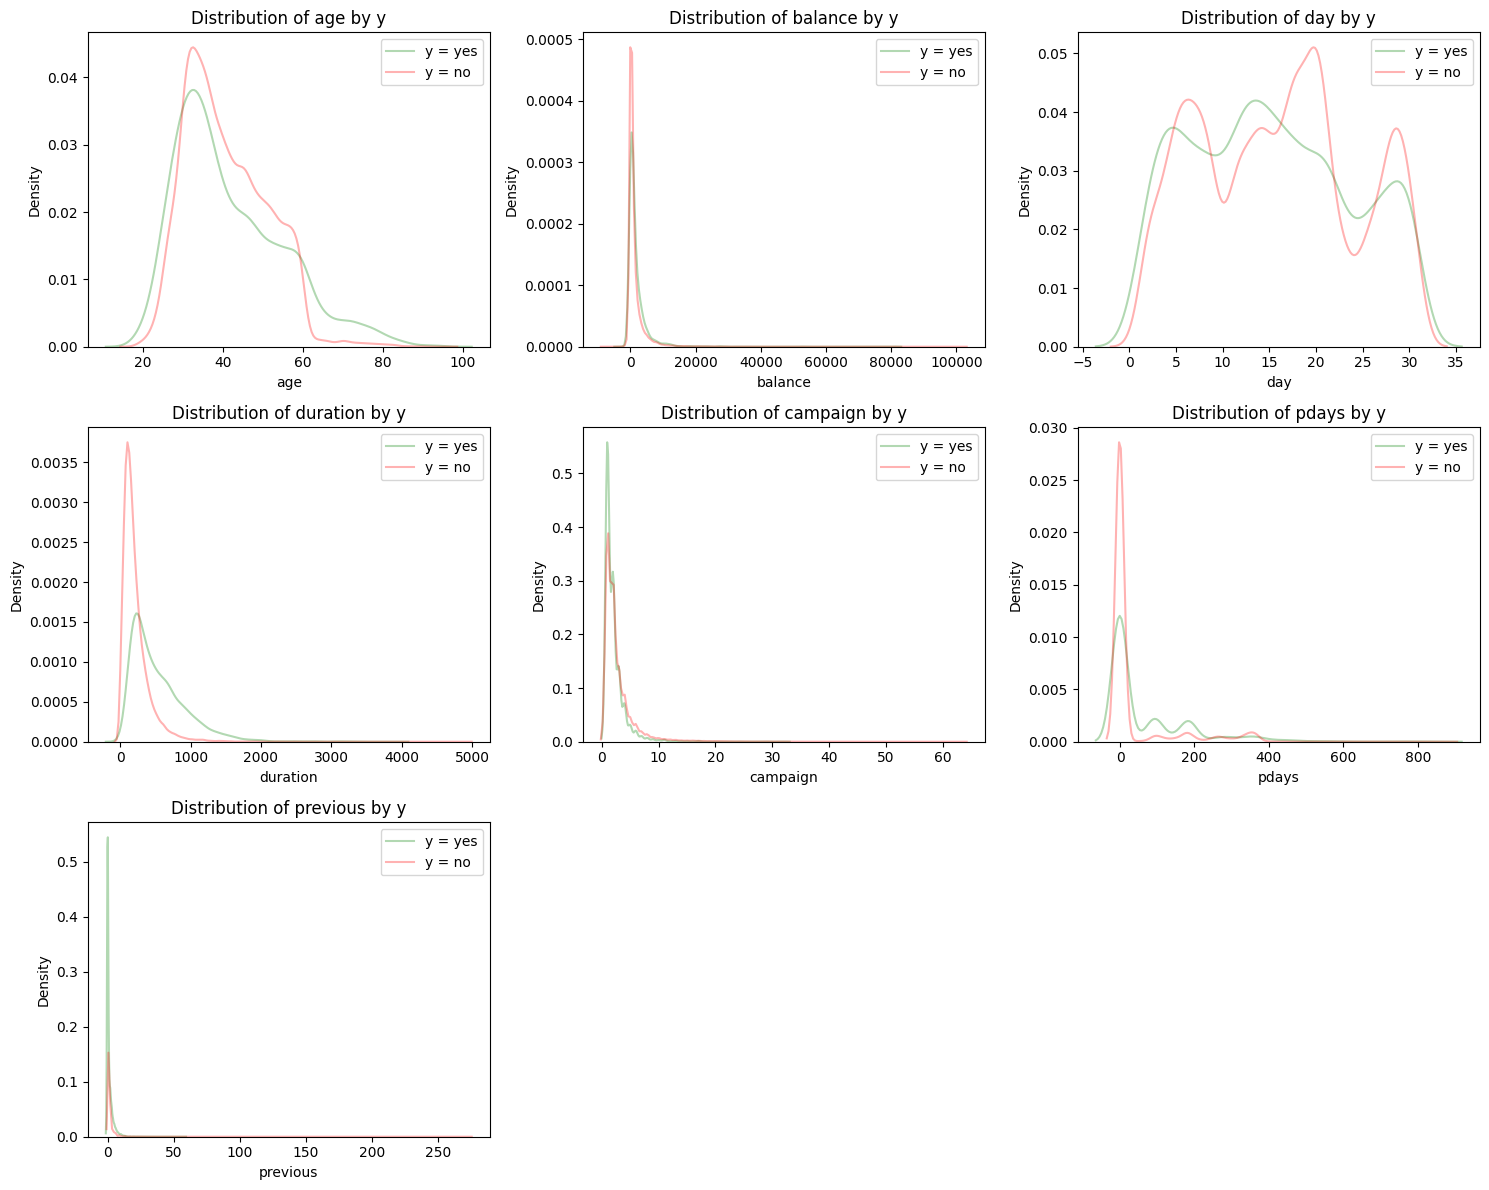

In [106]:

variables = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Create a 3x3 subplot
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# Loop over variables
for i, var in enumerate(variables):
    ax = axes[i]
    
    df_plot = df.copy()
    
    # Plot distributions by 'y'
    sns.kdeplot(df_plot[df_plot['y'] == 'yes'][var], ax=ax, color='green', fill=False, alpha=0.3, label='y = yes')
    sns.kdeplot(df_plot[df_plot['y'] == 'no'][var], ax=ax, color='red', fill=False, alpha=0.3, label='y = no')
    
    ax.set_title(f'Distribution of {var} by y')
    ax.set_xlabel(var)
    ax.set_ylabel('Density')
    ax.legend()

# Remove unused axes if any
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Target: Subscribe or not subscribe

In [107]:


percentages = df['y'].value_counts(normalize=True) * 100


print("Proportion in the target variable: ",percentages)

df["y"] = df["y"].map({"yes": True, "no": False})

Proportion in the target variable:  y
no     88.30152
yes    11.69848
Name: proportion, dtype: float64


## Balance

The varible balance in the top 1% doesn't add relevant information about how different the target's distribution is compared to how it is in whole datasets. Therefore, the variable is capped in the 99th percentile. 

In [108]:
upper_bound = df['balance'].quantile(0.99)

df_99 = df[df['balance']>= upper_bound]

percentages_outliers = df_99['y'].value_counts(normalize=True) * 100
print("Proportion when filtering the top 1% in the target variable: ",percentages_outliers)

Proportion when filtering the top 1% in the target variable:  y
False    88.07947
True     11.92053
Name: proportion, dtype: float64


In [109]:
df['balance'] = df['balance'].clip(upper=upper_bound)

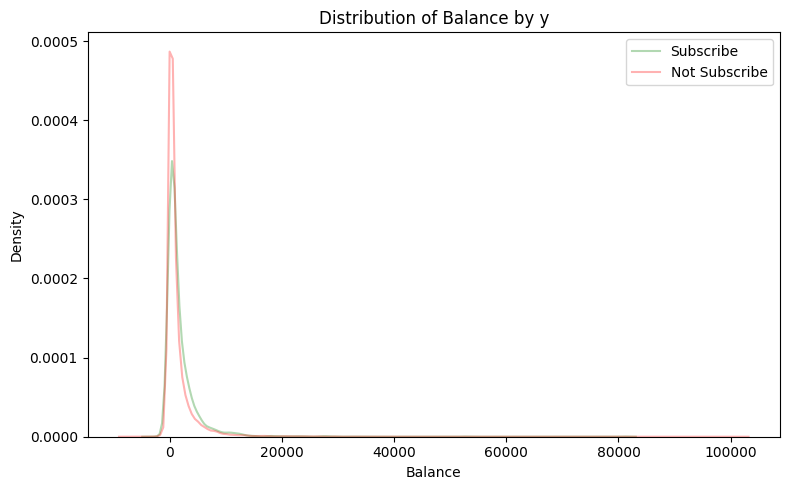

In [110]:
plt.figure(figsize=(8,5))

# Plot KDE by 'y'
sns.kdeplot(df_plot[df_plot['y'] == 'yes']['balance'], color='green', fill=False, alpha=0.3, label='Subscribe')
sns.kdeplot(df_plot[df_plot['y'] == 'no']['balance'], color='red', fill=False, alpha=0.3, label='Not Subscribe')

plt.title('Distribution of Balance by y')
plt.xlabel('Balance')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## campaign

In the case of campaign, the first 1% of the variable have a meaningful different between the "yes" percentage compared to the overall dataset. 

In [111]:
upper_bound = df['campaign'].quantile(0.90)

df_99 = df[df['campaign']>= upper_bound]

print(upper_bound)
percentages_outliers = df_99['y'].value_counts(normalize=True) * 100
print("Proportion when filtering the top 1% in the target variable: ",percentages_outliers)

5.0
Proportion when filtering the top 1% in the target variable:  y
False    93.593724
True      6.406276
Name: proportion, dtype: float64


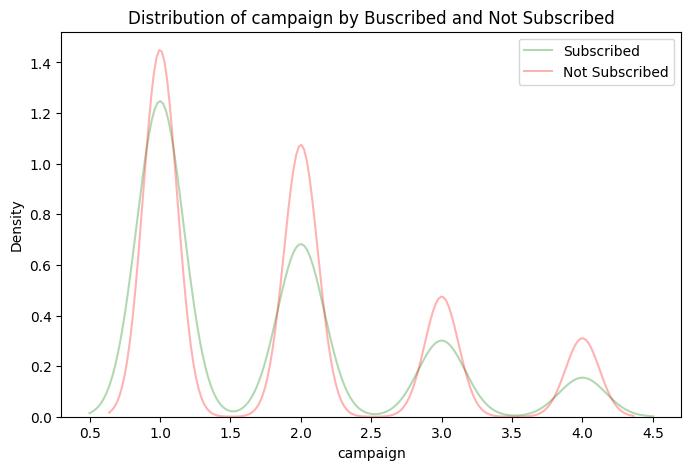

In [112]:
name_variable = "campaign"

df_plot = df[df[name_variable] < upper_bound]
plt.figure(figsize=(8,5))

# Plot KDE by 'y'
sns.kdeplot(df_plot[df_plot['y'] == True][name_variable], color='green', fill=False, alpha=0.3, label='Subscribed')
sns.kdeplot(df_plot[df_plot['y'] == False][name_variable], color='red', fill=False, alpha=0.3, label='Not Subscribed')

plt.title(f'Distribution of {name_variable} by Buscribed and Not Subscribed')
plt.xlabel(name_variable)
plt.ylabel('Density')
plt.legend()
plt.show()

## p days

In [113]:
upper_bound = df['pdays'].quantile(0.99)

df_99 = df[df['pdays']>= upper_bound]

print(upper_bound)
percentages_outliers = df_99['y'].value_counts(normalize=True) * 100
print("Proportion in the target variable: ",percentages_outliers)

370.0
Proportion in the target variable:  y
False    63.429752
True     36.570248
Name: proportion, dtype: float64


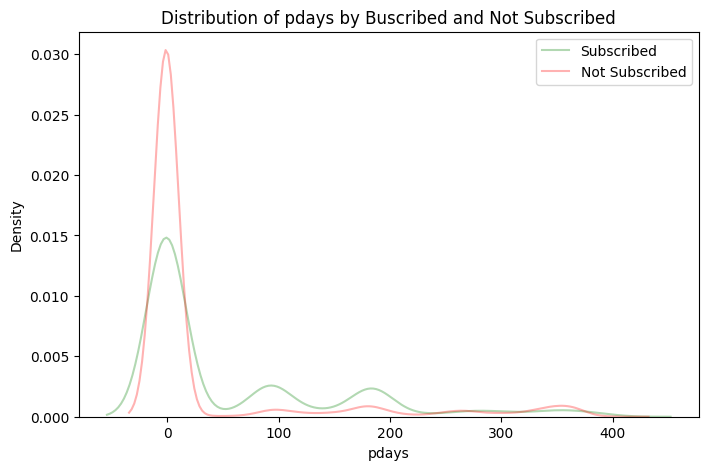

In [114]:
name_variable = "pdays"

df_plot = df[df[name_variable] < 400]
plt.figure(figsize=(8,5))

# Plot KDE by 'y'
sns.kdeplot(df_plot[df_plot['y'] == True][name_variable], color='green', fill=False, alpha=0.3, label='Subscribed')
sns.kdeplot(df_plot[df_plot['y'] == False][name_variable], color='red', fill=False, alpha=0.3, label='Not Subscribed')

plt.title(f'Distribution of {name_variable} by Buscribed and Not Subscribed')
plt.xlabel(name_variable)
plt.ylabel('Density')
plt.legend()
plt.show()

In [115]:
df['months_since_previous_contact'] = pd.cut(
    df['pdays'],
    bins=[-2,-1,150,230,310,380,1000],   # intervals
    labels=[
        "No contact",
        "0 - 5 months", "5 - 8 months", "8 - 11 months", "Around a year", "More than a year"
    ]
)

df['months_since_previous_contact'].value_counts()

months_since_previous_contact
No contact          36954
0 - 5 months         2346
5 - 8 months         2228
Around a year        2035
8 - 11 months        1353
More than a year      295
Name: count, dtype: int64

C:\Users\crist\AppData\Local\Temp\ipykernel_26860\560469242.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


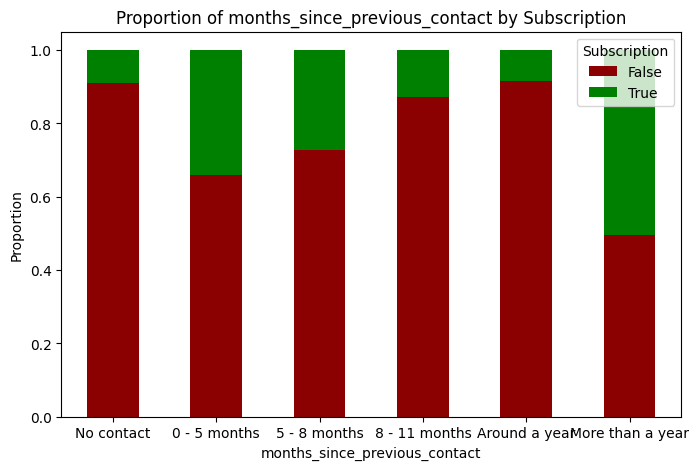

In [116]:

name_variable = "months_since_previous_contact"
counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


# Normalize row-wise → proportions per contact category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind="bar",
    stacked=True,       # stacked to see proportion in same bar
    figsize=(8,5),
    color={False: "darkred", True: "green"}
)

plt.title(f'Proportion of {name_variable} by Subscription')
plt.xlabel(name_variable)
plt.ylabel('Proportion')
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.show()

## Previuos

In [117]:
upper_bound = df['previous'].quantile(0.99)

df_99 = df[df['previous']>= upper_bound]

print(upper_bound)
percentages_outliers = df_99['y'].value_counts(normalize=True) * 100
print("Proportion in the target variable: ",percentages_outliers)

8.900000000001455
Proportion in the target variable:  y
False    77.041943
True     22.958057
Name: proportion, dtype: float64


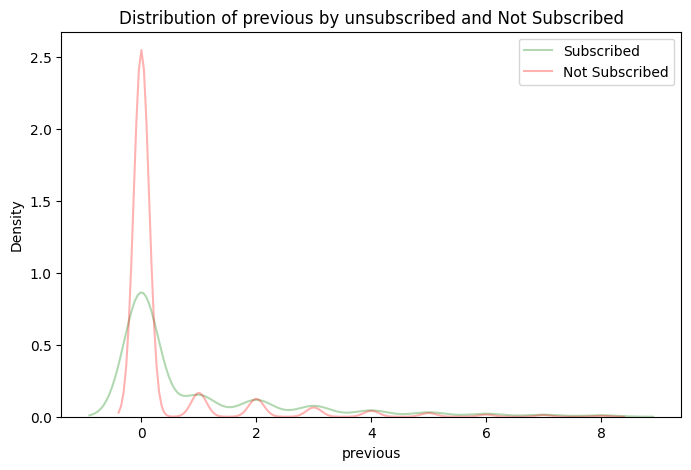

In [118]:
%matplotlib inline


# Filter full dataframe (keep balance < 20000)

name_variable = "previous"

df_plot = df[df['previous'] < 9]
plt.figure(figsize=(8,5))

# Plot KDE by 'y'
sns.kdeplot(df_plot[df_plot['y'] == True][name_variable], color='green', fill=False, alpha=0.3, label='Subscribed')
sns.kdeplot(df_plot[df_plot['y'] == False][name_variable], color='red', fill=False, alpha=0.3, label='Not Subscribed')

plt.title(f'Distribution of {name_variable} by unsubscribed and Not Subscribed')
plt.xlabel(name_variable)
plt.ylabel('Density')
plt.legend()
plt.show()


In [119]:
df['n_previous_contacts'] = pd.cut(
    df['previous'],
    bins=[-1,0,1,2,3,4,5,6,300],   # intervals
    labels=[
        "No contact",
        "1", "2", "3", "4", "5", "6",
        "More than 6"
    ]
)

df['n_previous_contacts'].value_counts()

n_previous_contacts
No contact     36954
1               2772
2               2106
3               1142
More than 6      787
4                714
5                459
6                277
Name: count, dtype: int64

C:\Users\crist\AppData\Local\Temp\ipykernel_26860\4042863158.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


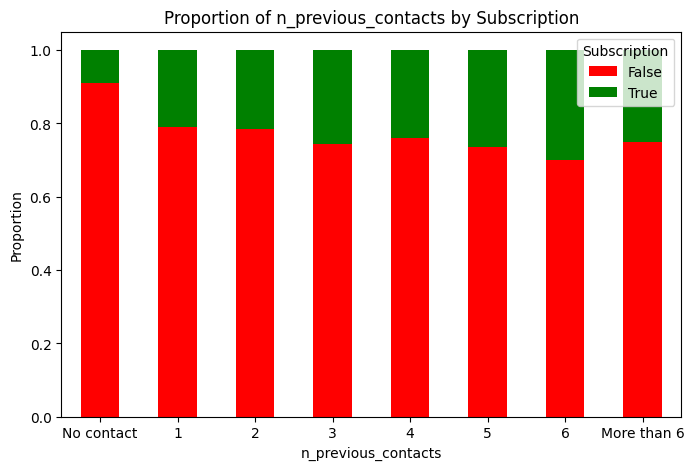

In [120]:
name_variable = "n_previous_contacts"

counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


# Normalize row-wise → proportions per contact category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind="bar",
    stacked=True,       # stacked to see proportion in same bar
    figsize=(8,5),
    color={False: "red", True: "green"}
)

plt.title(f'Proportion of {name_variable} by Subscription')
plt.xlabel(name_variable)
plt.ylabel('Proportion')
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.show()

In [121]:
count_matrix = pd.crosstab(df["n_previous_contacts"], df["months_since_previous_contact"])

# Percentages (by total)
percentage_matrix = pd.crosstab(df["n_previous_contacts"], df["months_since_previous_contact"], normalize="all") * 100

# Percentages (row-wise, if you want distribution per gender)
percentage_row = pd.crosstab(df["n_previous_contacts"], df["months_since_previous_contact"], normalize="index") * 100

print("Counts:")
print(count_matrix, "\n")

print("Percentages (overall):")
print(percentage_matrix, "\n")

print("Percentages (row-wise):")
print(percentage_row)

Counts:
months_since_previous_contact  No contact  0 - 5 months  5 - 8 months  \
n_previous_contacts                                                     
No contact                          36954             0             0   
1                                       0           685           737   
2                                       0           565           557   
3                                       0           361           311   
4                                       0           220           195   
5                                       0           161           131   
6                                       0           100            80   
More than 6                             0           254           217   

months_since_previous_contact  8 - 11 months  Around a year  More than a year  
n_previous_contacts                                                            
No contact                                 0              0                 0  
1                    

In [122]:
df_grouped = df.groupby(["n_previous_contacts", "months_since_previous_contact"])["y"].mean()
print(df_grouped)

n_previous_contacts  months_since_previous_contact
No contact           No contact                       0.091573
                     0 - 5 months                          NaN
                     5 - 8 months                          NaN
                     8 - 11 months                         NaN
                     Around a year                         NaN
                     More than a year                      NaN
1                    No contact                            NaN
                     0 - 5 months                     0.324088
                     5 - 8 months                     0.229308
                     8 - 11 months                    0.127473
                     Around a year                    0.084918
                     More than a year                 0.632075
2                    No contact                            NaN
                     0 - 5 months                     0.313274
                     5 - 8 months                     0.276481
    

C:\Users\crist\AppData\Local\Temp\ipykernel_26860\422558207.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby(["n_previous_contacts", "months_since_previous_contact"])["y"].mean()


## Correlation matrix analysis

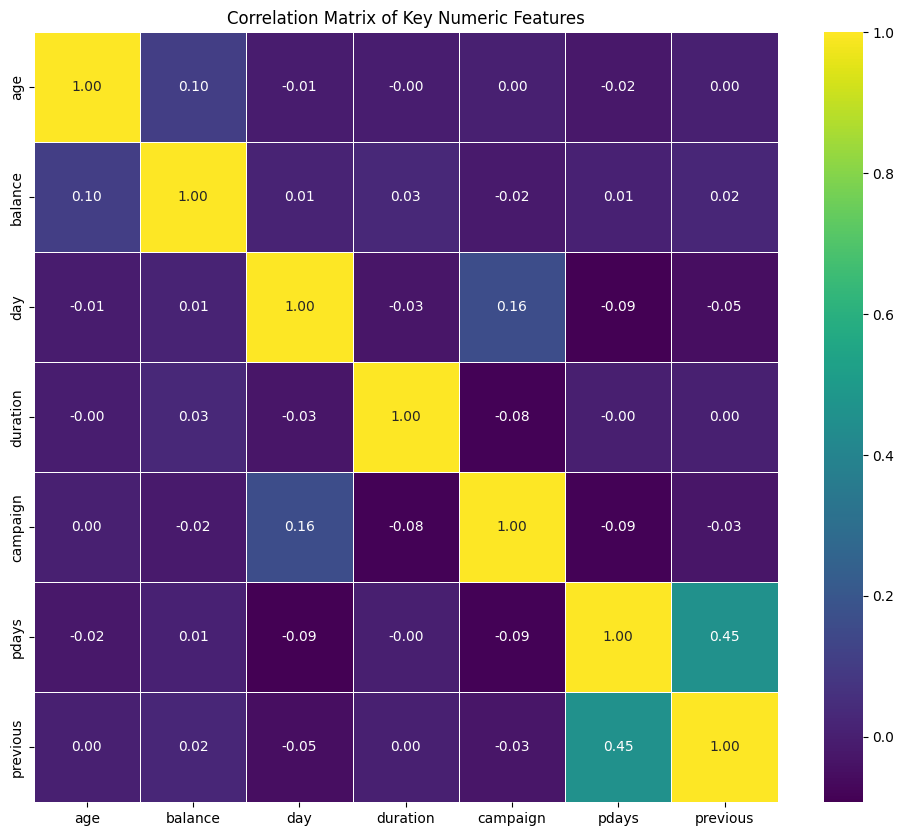

In [123]:

corr_matrix = df[variables].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Key Numeric Features')
plt.show()

## Categorical Varable Analysis

### job

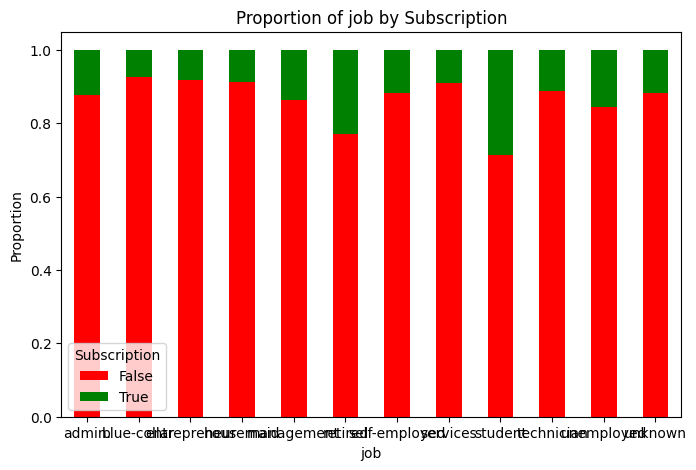

In [124]:

name_variable = "job"
counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


# Normalize row-wise → proportions per contact category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind="bar",
    stacked=True,       # stacked to see proportion in same bar
    figsize=(8,5),
    color={False: "red", True: "green"}
)

plt.title(f'Proportion of {name_variable} by Subscription')
plt.xlabel(name_variable)
plt.ylabel('Proportion')
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.show()

In [125]:
print(proportions)

y                 False     True 
job                              
admin.         0.877973  0.122027
blue-collar    0.927250  0.072750
entrepreneur   0.917283  0.082717
housemaid      0.912097  0.087903
management     0.862444  0.137556
retired        0.772085  0.227915
self-employed  0.881571  0.118429
services       0.911170  0.088830
student        0.713220  0.286780
technician     0.889430  0.110570
unemployed     0.844973  0.155027
unknown        0.881944  0.118056


### Marital

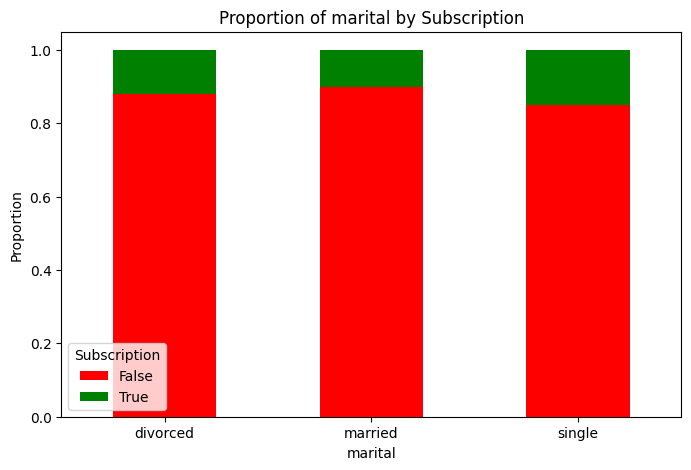

In [126]:
name_variable = "marital"
counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


# Normalize row-wise → proportions per contact category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind="bar",
    stacked=True,       # stacked to see proportion in same bar
    figsize=(8,5),
    color={False: "red", True: "green"}
)

plt.title(f'Proportion of {name_variable} by Subscription')
plt.xlabel(name_variable)
plt.ylabel('Proportion')
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.show()

In [127]:
print(proportions)

y            False     True 
marital                     
divorced  0.880545  0.119455
married   0.898765  0.101235
single    0.850508  0.149492


### Education


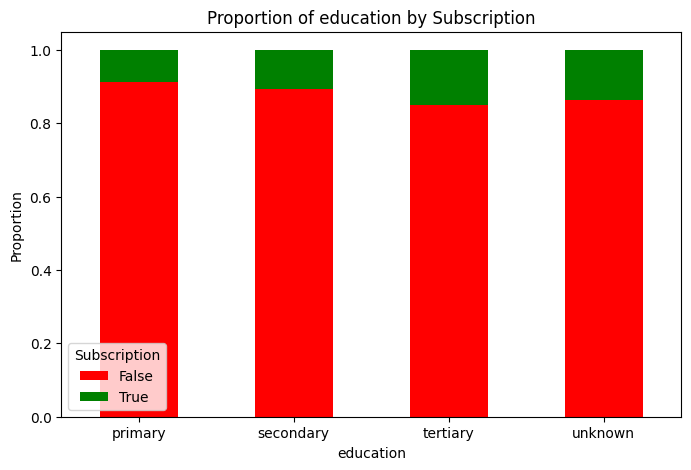

In [128]:
name_variable = "education"
counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


# Normalize row-wise → proportions per contact category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind="bar",
    stacked=True,       # stacked to see proportion in same bar
    figsize=(8,5),
    color={False: "red", True: "green"}
)

plt.title(f'Proportion of {name_variable} by Subscription')
plt.xlabel(name_variable)
plt.ylabel('Proportion')
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.show()

In [129]:
print(proportions)

y             False     True 
education                    
primary    0.913735  0.086265
secondary  0.894406  0.105594
tertiary   0.849936  0.150064
unknown    0.864297  0.135703


### loan

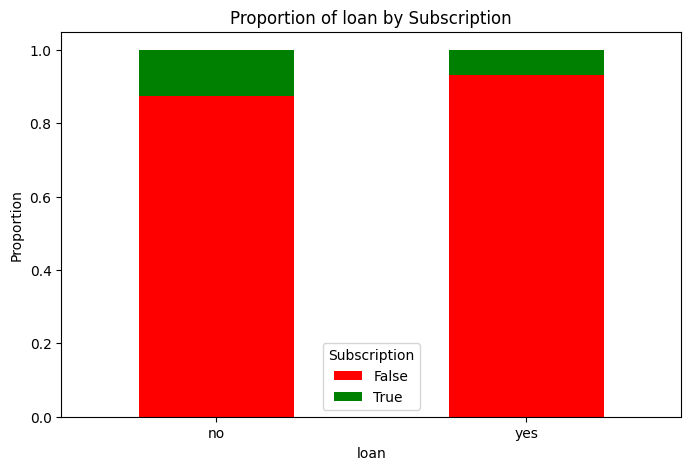

In [130]:
name_variable = "loan"
counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


# Normalize row-wise → proportions per contact category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind="bar",
    stacked=True,       # stacked to see proportion in same bar
    figsize=(8,5),
    color={False: "red", True: "green"}
)

plt.title(f'Proportion of {name_variable} by Subscription')
plt.xlabel(name_variable)
plt.ylabel('Proportion')
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.show()

In [131]:
print(proportions)

y        False     True 
loan                    
no    0.873443  0.126557
yes   0.933186  0.066814


### housing

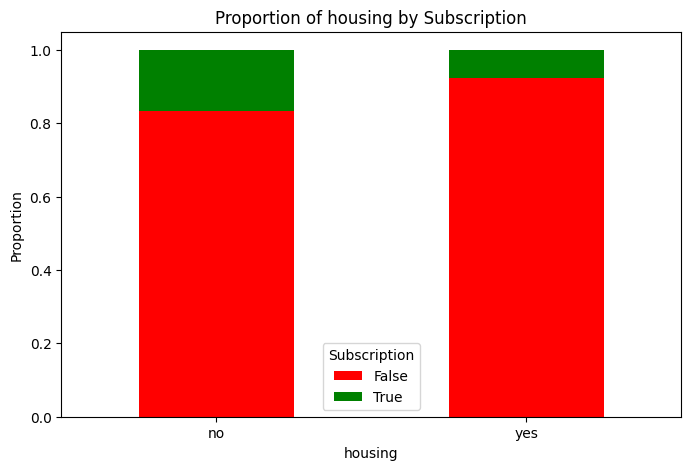

In [132]:
name_variable = "housing"
counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


# Normalize row-wise → proportions per contact category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind="bar",
    stacked=True,       # stacked to see proportion in same bar
    figsize=(8,5),
    color={False: "red", True: "green"}
)

plt.title(f'Proportion of {name_variable} by Subscription')
plt.xlabel(name_variable)
plt.ylabel('Proportion')
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.show()

In [133]:
print(proportions)

y           False     True 
housing                    
no       0.832976  0.167024
yes      0.923000  0.077000


### default

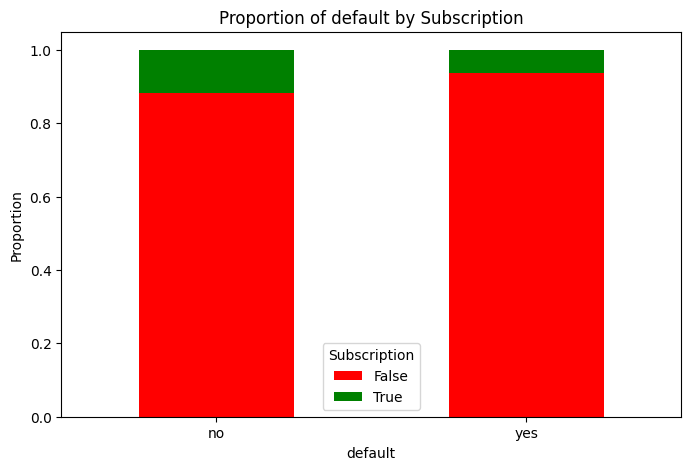

In [134]:
name_variable = "default"
counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


# Normalize row-wise → proportions per contact category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind="bar",
    stacked=True,       # stacked to see proportion in same bar
    figsize=(8,5),
    color={False: "red", True: "green"}
)

plt.title(f'Proportion of {name_variable} by Subscription')
plt.xlabel(name_variable)
plt.ylabel('Proportion')
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.show()

In [135]:
print(proportions)

y           False     True 
default                    
no       0.882039  0.117961
yes      0.936196  0.063804


### Contact

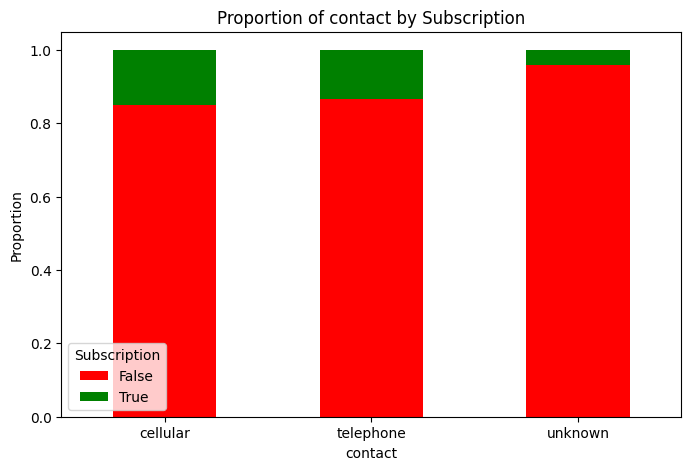

In [136]:
name_variable = "contact"
counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


# Normalize row-wise → proportions per contact category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind="bar",
    stacked=True,       # stacked to see proportion in same bar
    figsize=(8,5),
    color={False: "red", True: "green"}
)

plt.title(f'Proportion of {name_variable} by Subscription')
plt.xlabel(name_variable)
plt.ylabel('Proportion')
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.show()

### poutcome

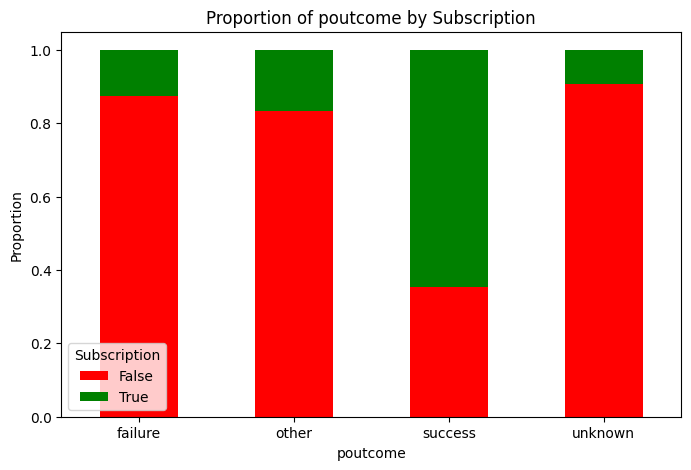

In [137]:
name_variable = "poutcome"
counts = df.groupby([name_variable, "y"]).size().unstack(fill_value=0)


# Normalize row-wise → proportions per contact category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind="bar",
    stacked=True,       # stacked to see proportion in same bar
    figsize=(8,5),
    color={False: "red", True: "green"}
)

plt.title(f'Proportion of {name_variable} by Subscription')
plt.xlabel(name_variable)
plt.ylabel('Proportion')
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.show()

## Variable Creation

### Contact or no Contact

In [138]:
df["had_contact"] = df["months_since_previous_contact"] != "No contact"

### Is single?

In [139]:
df["is_single"] = df["marital"] == "single"
df["is_single"].value_counts()

is_single
False    32421
True     12790
Name: count, dtype: int64

Uknown contact information?

In [140]:
df["uknown_contact"] = df["contact"] == "unknown"
df["uknown_contact"].value_counts()

uknown_contact
False    32191
True     13020
Name: count, dtype: int64

## Heuristic Logic

In [141]:
df_yes_likely = df[((df["age"] > 55)  | (df["age"] < 35)) & (df["balance"] > 800)& (df["day"] < 15)& (df["pdays"] > 0)]

df_yes_likely.info()
percentage= df_yes_likely['y'].value_counts(normalize=True) * 100
print("Proportion in the target variable: ",percentage)


<class 'pandas.core.frame.DataFrame'>
Index: 788 entries, 24136 to 45179
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   age                            788 non-null    int64   
 1   job                            788 non-null    object  
 2   marital                        788 non-null    object  
 3   education                      788 non-null    object  
 4   default                        788 non-null    object  
 5   balance                        788 non-null    float64 
 6   housing                        788 non-null    object  
 7   loan                           788 non-null    object  
 8   contact                        788 non-null    object  
 9   day                            788 non-null    int64   
 10  month                          788 non-null    object  
 11  duration                       788 non-null    int64   
 12  campaign                       788 

## Model

### Spliting the dataset

In [142]:
month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
 
df['month_num'] = df['month'].map(month_map)
 
# Start with 2008
year = 2008
years = []
prev_month = df['month_num'].iloc[0]
 
for m in df['month_num']:
    # If the month goes backwards (e.g., from Dec → Jan or Oct → Mar), increment year
    if m < prev_month:
        year += 1
    years.append(year)
    prev_month = m
 
df['year'] = years
 
# Finally, build datetime column
df['date'] = pd.to_datetime(dict(year=df['year'], month=df['month_num'], day=df['day']))
 
print(df[['day','month','year','date']].head(20))

    day month  year       date
0     5   may  2008 2008-05-05
1     5   may  2008 2008-05-05
2     5   may  2008 2008-05-05
3     5   may  2008 2008-05-05
4     5   may  2008 2008-05-05
5     5   may  2008 2008-05-05
6     5   may  2008 2008-05-05
7     5   may  2008 2008-05-05
8     5   may  2008 2008-05-05
9     5   may  2008 2008-05-05
10    5   may  2008 2008-05-05
11    5   may  2008 2008-05-05
12    5   may  2008 2008-05-05
13    5   may  2008 2008-05-05
14    5   may  2008 2008-05-05
15    5   may  2008 2008-05-05
16    5   may  2008 2008-05-05
17    5   may  2008 2008-05-05
18    5   may  2008 2008-05-05
19    5   may  2008 2008-05-05


In [143]:
df['year_moth'] = pd.to_datetime(dict(year=df['year'], month=df['month_num'], day="01"))

counts_dates = df["year_moth"].value_counts().sort_index()

# Percentage of total
percent = counts_dates / counts_dates.sum() * 100

# Cumulative percentage
cum_percent = percent.cumsum()

# Combine into one DataFrame
summary = pd.DataFrame({
    "n": counts_dates,
    "percent": percent,
    "cum_percent": cum_percent
})

print(summary)

               n    percent  cum_percent
year_moth                               
2008-05-01  7957  17.599699    17.599699
2008-06-01  4486   9.922364    27.522063
2008-07-01  6380  14.111610    41.633673
2008-08-01  5215  11.534803    53.168477
2008-10-01    80   0.176948    53.345425
2008-11-01  3598   7.958240    61.303665
2008-12-01    13   0.028754    61.332419
2009-01-01  1176   2.601137    63.933556
2009-02-01  2296   5.078410    69.011966
2009-03-01   258   0.570658    69.582624
2009-04-01  2718   6.011811    75.594435
2009-05-01  5575  12.331070    87.925505
2009-06-01   642   1.420008    89.345513
2009-07-01   207   0.457853    89.803366
2009-08-01   772   1.707549    91.510915
2009-09-01   282   0.623742    92.134657
2009-10-01   438   0.968791    93.103448
2009-11-01   297   0.656920    93.760368
2009-12-01   201   0.444582    94.204950
2010-01-01   227   0.502090    94.707040
2010-02-01   353   0.780783    95.487824
2010-03-01   219   0.484395    95.972219
2010-04-01   214

In [144]:
# df = df.drop(["marital", "contact", "month", "duration", "pdays", "previous", "poutcome", "year_moth", "date", "month_num", "year"], axis=1)
# df.info()

In [145]:
df["job"] = df["job"].astype("category")
df["education"] = df["education"].astype("category")
df["default"] = df["default"].astype("category")
df["housing"] = df["housing"].astype("category")
df["loan"] = df["loan"].astype("category")

In [156]:
numeric_features = [
    'age', 'balance', 'day', 'campaign'
]
categorical_features = ['job', 'education', 'default', "housing", "loan", "months_since_previous_contact" , "n_previous_contacts" ]
boolean_features = ['had_contact', 'is_single', 'uknown_contact']

# Combine all features
all_features = numeric_features + categorical_features + boolean_features
target = 'y'

fecha_train = "2008-11-01"
fecha_test = "2009-05-01"

df_model = df.drop(["marital", "contact", "month", "duration", "pdays", "previous", "poutcome", "date", "month_num", "year"], axis=1)

df_train = df_model[df_model["year_moth"]<=fecha_train]

df_validation = df_model[(df_model["year_moth"]>fecha_train)&(df_model["year_moth"]<fecha_test)]

df_test = df_model[df_model["year_moth"]>=fecha_test]

df_train = df_train.drop("year_moth", axis = 1)
df_validation = df_validation.drop("year_moth", axis = 1)
df_test = df_test.drop("year_moth", axis = 1)

print(f"Training set shape:   {df_train.shape}")
print(f"Validation set shape: {df_validation.shape}")
print(f"Test set shape:       {df_test.shape}")

n_total = df_train.shape[0]+df_validation.shape[0]+df_test.shape[0]
print(f"Total of rows:   {n_total}")


Training set shape:   (27716, 15)
Validation set shape: (6461, 15)
Test set shape:       (11034, 15)
Total of rows:   45211


In [157]:

X_train = df_train.drop(columns=[target])
y_train = df_train[target]

X_val = df_validation.drop(columns=[target])
y_val = df_validation[target]

X_test = df_test.drop(columns=[target])
y_test = df_test[target]


### Pipeline

In [158]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

In [151]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27716 entries, 0 to 27715
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   age                            27716 non-null  int64         
 1   job                            27716 non-null  category      
 2   marital                        27716 non-null  object        
 3   education                      27716 non-null  category      
 4   default                        27716 non-null  category      
 5   balance                        27716 non-null  float64       
 6   housing                        27716 non-null  category      
 7   loan                           27716 non-null  category      
 8   contact                        27716 non-null  object        
 9   day                            27716 non-null  int64         
 10  month                          27716 non-null  object        
 11  duration            

In [164]:
# --- Baseline Model (Dummy Classifier) ---
dummy_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', DummyClassifier(strategy='stratified'))])
dummy_pipeline.fit(X_train, y_train)
y_pred_dummy_proba = dummy_pipeline.predict_proba(X_val)[:, 1]
roc_auc_dummy = roc_auc_score(y_val, y_pred_dummy_proba)
print(f"Baseline (Dummy) ROC AUC: {roc_auc_dummy:.4f}")

# --- Logistic Regression ---
logreg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))])
logreg_pipeline.fit(X_train, y_train)
y_pred_logreg_proba = logreg_pipeline.predict_proba(X_val)[:, 1]
roc_auc_logreg = roc_auc_score(y_val, y_pred_logreg_proba)
print(f"Logistic Regression ROC AUC: {roc_auc_logreg:.4f}")

# --- Random Forest ---
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])
rf_pipeline.fit(X_train, y_train)
y_pred_rf_proba = rf_pipeline.predict_proba(X_val)[:, 1]
roc_auc_rf = roc_auc_score(y_val, y_pred_rf_proba)
print(f"Random Forest ROC AUC: {roc_auc_rf:.4f}")



Baseline (Dummy) ROC AUC: 0.4984
Logistic Regression ROC AUC: 0.6157
Random Forest ROC AUC: 0.5704


In [168]:

# Get the trained logistic regression model
logreg_model = logreg_pipeline.named_steps["classifier"]

# Get feature names after preprocessing
feature_names = logreg_pipeline.named_steps["preprocessor"].get_feature_names_out()

# Extract coefficients
coefficients = logreg_model.coef_[0]

# Put into a DataFrame
importance = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients,
    "odds_ratio": np.exp(coefficients)
}).sort_values(by="coefficient", key=abs, ascending=False)

print(importance.head(15))  # top 15 most important

                                            feature  coefficient  odds_ratio
33                       cat__n_previous_contacts_5    -1.634774    0.194996
34                       cat__n_previous_contacts_6     0.696270    2.006256
29                       cat__n_previous_contacts_1     0.464288    1.590881
15                                 cat__job_unknown    -0.437523    0.645634
27  cat__months_since_previous_contact_5 - 8 months    -0.324794    0.722676
14                              cat__job_unemployed     0.289762    1.336109
7                                cat__job_housemaid    -0.279268    0.756337
9                                  cat__job_retired     0.209541    1.233112
32                       cat__n_previous_contacts_4     0.201186    1.222852
30                       cat__n_previous_contacts_2     0.174332    1.190450
12                                 cat__job_student     0.160881    1.174545
23                                 cat__housing_yes    -0.160385    0.851816

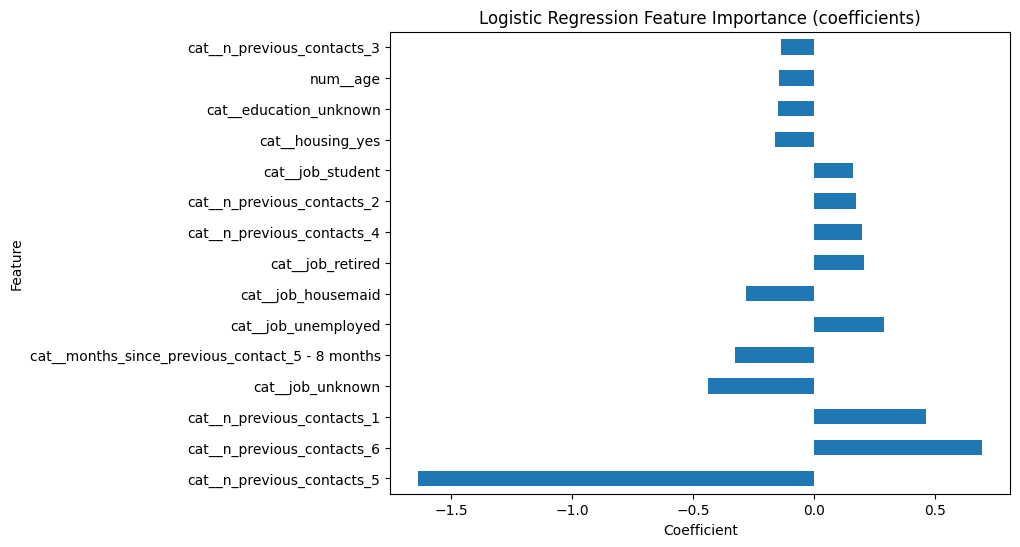

In [169]:
import matplotlib.pyplot as plt

top_n = 15  # top features to display
importance.head(top_n).set_index("feature")["coefficient"].plot(kind="barh", figsize=(8,6))
plt.title("Logistic Regression Feature Importance (coefficients)")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()


In [171]:

# --- XGBoost (Initial) ---
# Calculate scale_pos_weight for handling imbalance
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"Calculated scale_pos_weight for XGBoost: {scale_pos_weight:.2f}")

xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', xgb.XGBClassifier(objective='binary:logistic', random_state=42,
                                                                use_label_encoder=False, eval_metric='logloss'))])
# We will train our final model later after choosing it
# For now, let's just create the pipeline and train it on the train set for evaluation
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb_proba = xgb_pipeline.predict_proba(X_val)[:, 1]
roc_auc_xgb = roc_auc_score(y_val, y_pred_xgb_proba)
print(f"XGBoost (Initial) ROC AUC: {roc_auc_xgb:.4f}")

Calculated scale_pos_weight for XGBoost: 18.80
XGBoost (Initial) ROC AUC: 0.5686


c:\Users\crist\OneDrive - Aalborg Universitet\Assignments\M1_final_assignment\final_assignment_bank_campaign\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:50:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
